# Import libraries 

In [19]:
import pandas as pd 
import json 
import numpy as np 
import pdal 
import warnings 
warnings.filterwarnings('ignore')
from pyproj import Proj, transform
from shapely.geometry import Polygon, Point, mapping
import geopandas as gpd
import matplotlib.pyplot as plt 

# Data Fetching 

In [2]:
def json_load(filepath):
    """
    - function to load json file 
    """
    try:
        with open(filepath) as file:
            json_file = json.load(file)
        return json_file
    except FileNotFoundError:
        print('this is file is not found')

In [3]:
def convert_EPSG(fromT, lon, lat):
    """
    -- function to change to the needed CRS format for better visualization
    parameters:
    
    1. fromT: original EPSG format
    2. lon: longitude
    3. lat: latitude
    
    WGS84 is the most common global CRS in latitude and longitude and it have
    "init=epsg4326" that will be used in this function 
    
    """
    
    P3857 = Proj(init='epsg:3857')
    P4326 = Proj(init='epsg:4326')
    if(fromT == 4326):
        input1 = P4326
        input2 = P3857
        
    else:
        input1 = p3857
        input2 = p4326
        
    x, y = transform(input1,input2,lon,lat)
    return [x, y]

In [4]:
def loop_EPSG_converter(List):
    """
    -- function to change format of a list of cordinates to a list of points 
    """
    converted_list = []
    for i in List:
        converted_list.append(convert_EPSG(4326, i[0], i[1]))
        
    return converted_list 
        

In [5]:
coordinates = [
    [-93.756055, 41.918115],
    [-93.756155, 41.918215],
    [-93.756396, 41.918475],
    [-93.755955, 41.918300],
    [-93.755795, 41.918000],
]
# change coordinates to a list of points
corr_list = loop_EPSG_converter(coordinates)
# polygon = generate_polygon(coordinates, 4326)
corr_list

[[-10436876.301386151, 5148721.349314567],
 [-10436887.43333523, 5148736.309605352],
 [-10436914.26133251, 5148775.206471106],
 [-10436865.169437071, 5148749.025870951],
 [-10436847.358318545, 5148704.145009145]]

In [6]:
def generate_polygon(coor, epsg):
    """
    --Generate a polygon given a co-ordinate and CRS format

    """
    polygon_g = Polygon(coor)
    crs = {'init': 'epsg:'+str(epsg)}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_g])       
    return polygon

In [7]:
polygon = generate_polygon(corr_list,4326)
polygon

,geometry
0,"POLYGON ((-10436876.30139 5148721.34931, -1043..."


In [29]:
def json_modification(json_filepath, url, region,espg_in, espg_out,polygon_):
    """
    -- function to modify json pipeline file to fetch data 
    """
    d = json_load(json_filepath)
    d['pipeline'][0]['polygon'] = str(polygon_.iloc[:,0][0])
    d['pipeline'][0]['filename'] = f"{url}/{region}/ept.json"
    d['pipeline'][2]['in_srs'] = f"EPSG:{espg_in}"
    d['pipeline'][2]['out_srs'] = f"EPSG:{espg_out}"
    return d
    

In [30]:
path = "../pipeline_json.json"
url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public"
region = "IA_FullState"
in_srs = 3857
out_srs = 4326
poly = polygon

In [31]:
# modifiy json file 
r = json_modification(path, url, region, in_srs, out_srs,poly)

In [32]:
r

{'pipeline': [{'polygon': 'POLYGON ((-10436876.301386151 5148721.349314567, -10436887.43333523 5148736.309605352, -10436914.26133251 5148775.206471106, -10436865.169437071 5148749.025870951, -10436847.358318545 5148704.145009145, -10436876.301386151 5148721.349314567))',
   'filename': 'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json',
   'type': 'readers.ept',
   'tag': 'readdata'},
  {'type': 'filters.range',
   'limits': 'Classification![7:7]',
   'tag': 'no_noise'},
  {'in_srs': 'EPSG:3857',
   'out_srs': 'EPSG:4326',
   'tag': 'reprojectUTM',
   'type': 'filters.reprojection'},
  {'filename': 'iowa.csv', 'tag': 'writerscsv', 'type': 'writers.text'},
  {'filename': 'iowa.las', 'tag': 'writersply', 'type': 'writers.las'}]}

In [33]:
# pipe creation
pipe = pdal.Pipeline(json.dumps(r))

In [34]:
# generate the dataframe  from the pipeline using created pipe 

def geo_df(pipe,epsg):
    elevations = []
    geometry_ = []
    counts = pipe.execute()
    arrays = pipe.arrays[0]
    
    for i in arrays:
        lists = list(i)[-3:]
        elevations.append(lists[2])
        geometry_.append(Point(lists[0],lists[1]))
        
    df = gpd.GeoDataFrame(columns=["elevation_m", "Geometry"])
    df['elevation_m'] = elevations
    df['Geometry'] = geometry_
    df = df.set_geometry('Geometry')
    df.set_crs(epsg = epsg, inplace=True)
    
    return df 

In [35]:
df = geo_df(pipe, 4326)

In [36]:
df.head()

,elevation_m,Geometry
0,310.37,POINT (-93.75581 41.91802)
1,310.56,POINT (-93.75582 41.91803)
2,310.33,POINT (-93.75585 41.91803)
3,310.42,POINT (-93.75587 41.91804)
4,310.30,POINT (-93.75584 41.91804)


# Visualization 

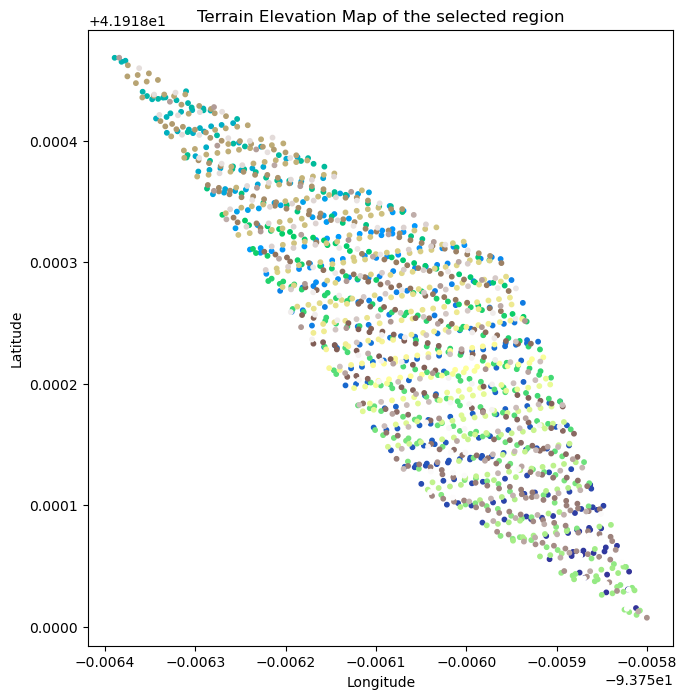

In [21]:
df.plot(c='elevation', scheme="quantiles", cmap='terrain', legend=True,markersize=10,figsize=(10,8))

plt.title('Terrain Elevation Map of the selected region')
plt.xlabel('Longitude')
plt.ylabel('Latitude');

In [60]:
def render_3d(df, title, p: float = 0.8) -> None:
    """ Plots a 3D terrain scatter plot for the cloud data points of geopandas data frame using matplotlib
    params:
        df: the data
        title: the title for generated image
        s: precision.
    return: none.
    """

    fig, ax = plt.subplots(1, 1, figsize=(10,8))
    ax = plt.axes(projection='3d')
    ax.scatter(df.Geometry.x, df.Geometry.y, df.elevation_m.values, s=p)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.title(title)
    plt.show()

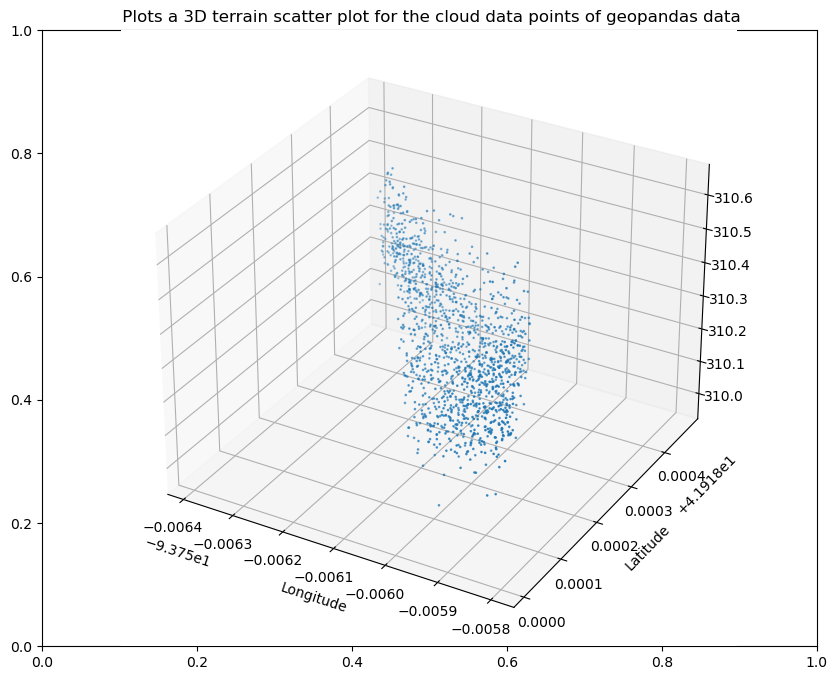

In [61]:
render_3d(df," Plots a 3D terrain scatter plot for the cloud data points of geopandas data")